# Imports

In [36]:
import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cmcrameri import cm

camels_spat_dir = Path('/gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_spat_NH')
shapes_dir = camels_spat_dir / 'merged_lumped_shapes'

# file_dir = Path('runs_928_cyril_camelsspat')
file_dir = Path('runs_928_cyril_camelsspat_ealstm19static')

# Load Data

In [37]:
# Load the results
result_df = pd.read_csv(file_dir / 'test_ensemble_metrics.csv')

# Ensure negative NSE values are set to zero
result_df['NSE'] = result_df['NSE'].apply(lambda x: max(x, 0))

# List of basins
basins = result_df['basin'].unique()

# Loading and reprojecting basins and states

In [38]:
## Read the basin shapefile
gdf_basins = gpd.read_file(shapes_dir / 'merged_lumped_outlines.shp')
# Subset the basins to only include the ones that are usable
gdf_basins = gdf_basins[gdf_basins['Station_id'].isin(basins)]

gdf_borders = gpd.read_file(camels_spat_dir / 'NA_PoliticalDivision' / 'boundaries_p_2021_v3.shp')
states = gpd.read_file(shapes_dir / 'USA_Canada_ShapefileMerge.shp')

gdf_basins.value_counts('Country')

Country
USA    474
CAN    441
Name: count, dtype: int64

In [39]:
# Ensure the CRS for gdf_basins
gdf_basins.crs = 'EPSG:4326'

# Set a common CRS for both GeoDataFrames
common_crs = 'ESRI:102008'
gdf_basins = gdf_basins.to_crs(common_crs)

# Compute the centroids of the basins after reprojection
gdf_basins['centroid'] = gdf_basins.geometry.centroid

# Ensure gdf_borders is in the same CRS
gdf_borders = gdf_borders.to_crs(common_crs)

In [40]:
# Merge the basin geometries with NSE values
gdf_basins = gdf_basins.merge(result_df[['basin', 'NSE']], left_on='Station_id', right_on='basin', how='left')

# Plot results

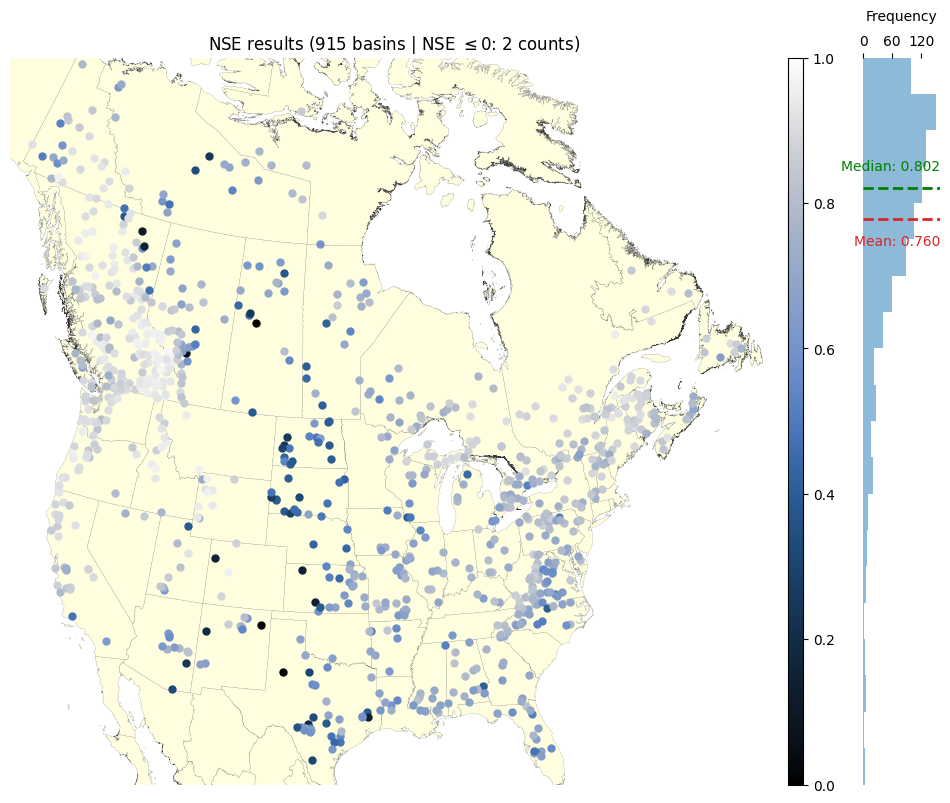

In [41]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# # Plot the reprojected gdf_borders
# gdf_borders.plot(ax=ax, facecolor='0.9', edgecolor='0.2', linewidth=0.1)
# Define the color options
color_options = {
    "Pale Yellow": "#FFFFE0",
    "Light Beige": "#F5F5DC",
    "Ivory": "#FFFFF0",
    "Light Yellow": "#FFFACD",
    "Lemon Chiffon": "#FFFACD",
    "Seashell": "#FFF5EE"
}
gdf_borders.plot(ax=ax, facecolor=color_options['Pale Yellow'], edgecolor='0.2', linewidth=0.1)

# # Define the colormap based on the metric values
# cmap = plt.cm.gnuplot
# norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # Adjust vmax to 1.0
## oslo, batlow, lajolla, imola, bamako, navia
cmap = cm.oslo # choose any colormap from cmcrameri
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # Adjust vmax to 1.

# Plot each basin using centroids
gdf_basins.apply(lambda row: ax.plot(row['centroid'].x, row['centroid'].y, 'o',
                                    markersize=5, color=cmap(norm(row['NSE'])),
                                    # markeredgewidth=0.2, markeredgecolor='k'
                                    ), 
                                    axis=1)

# Create an axis for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)

# Add a title
nse_less_than_0 = result_df['NSE'][result_df['NSE'] <= 0].count()
ax.set_title(f"NSE results ({len(result_df)} basins | NSE $\leq 0$: {nse_less_than_0} counts)")

# Add a histogram plot to the right of the colorbar
hist_ax = divider.append_axes("right", size="10%", pad=0.6)  # adjust pad as needed

hist_values = gdf_basins['NSE'].values
n_bins = 20
bins = np.linspace(hist_values.min(), hist_values.max(), n_bins + 1)

hist_ax.hist(hist_values, bins=bins, orientation='horizontal', color='tab:blue', alpha=0.5)
hist_ax.set_yticks([])  # remove y-ticks
hist_ax.set_ylim(hist_values.min(), hist_values.max())  # set y-axis limits to match the data range

# Adjust the x-ticks
xticks = hist_ax.get_xticks()
hist_ax.set_xticks(xticks[::3])  # set the x-ticks to every 3rd value
hist_ax.set_xlim(0, hist_ax.get_xlim()[1])  # set the right limit to the maximum value

# Move the x label to the top and adjust ticks
hist_ax.set_xlabel('')
hist_ax.xaxis.set_label_position('top')
hist_ax.set_xlabel('Frequency', labelpad=10)
hist_ax.xaxis.tick_top()
hist_ax.tick_params(axis='x', which='both', labeltop=True, labelbottom=False)

# Get rid of box lines
hist_ax.spines['top'].set_visible(False)
hist_ax.spines['right'].set_visible(False)
hist_ax.spines['bottom'].set_visible(False)
hist_ax.spines['left'].set_visible(False)

# Calculate the gap height based on the current ylim
gap = 0.04  # Gap between the line and the text label - histogram
ylim = hist_ax.get_ylim()
gap_height = gap * (ylim[1] - ylim[0])

# Add mean and median value plots to the histogram
mean_value = np.mean(hist_values)
median_value = np.median(hist_values)
max_value = max(mean_value, median_value)  # Find the greatest value

# Plot mean value
if mean_value < max_value:
    hist_ax.axhline(mean_value, color='tab:red', linestyle='--', linewidth=2)
    hist_ax.text(hist_ax.get_xlim()[1], mean_value - gap_height, f'Mean: {mean_value:.3f}', va='bottom', ha='right', color='tab:red')
else:
    hist_ax.axhline(mean_value, color='tab:red', linestyle='--', linewidth=2)
    hist_ax.text(hist_ax.get_xlim()[1], mean_value + gap_height, f'Mean: {mean_value:.3f}', va='top', ha='right', color='tab:red')

# Plot median value
if median_value < max_value:
    hist_ax.axhline(median_value, color='green', linestyle='--', linewidth=2)
    hist_ax.text(hist_ax.get_xlim()[1], median_value - gap_height, f'Median: {median_value:.3f}', va='bottom', ha='right', color='green')
else:
    hist_ax.axhline(median_value, color='green', linestyle='--', linewidth=2)
    hist_ax.text(hist_ax.get_xlim()[1], median_value + gap_height, f'Median: {median_value:.3f}', va='top', ha='right', color='green')

# Set chart junk
ax.set_xlim([-2.5*1e6, 3.1*1e6])
ax.set_ylim([-1.6*1e6, 3.7*1e6])
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Save the plot
plt.savefig(file_dir / 'nse_basins_map.png', dpi=150, bbox_inches='tight')

# Show the plot
plt.show()

## Background color options

/tmp/ipykernel_2334304/3951247708.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


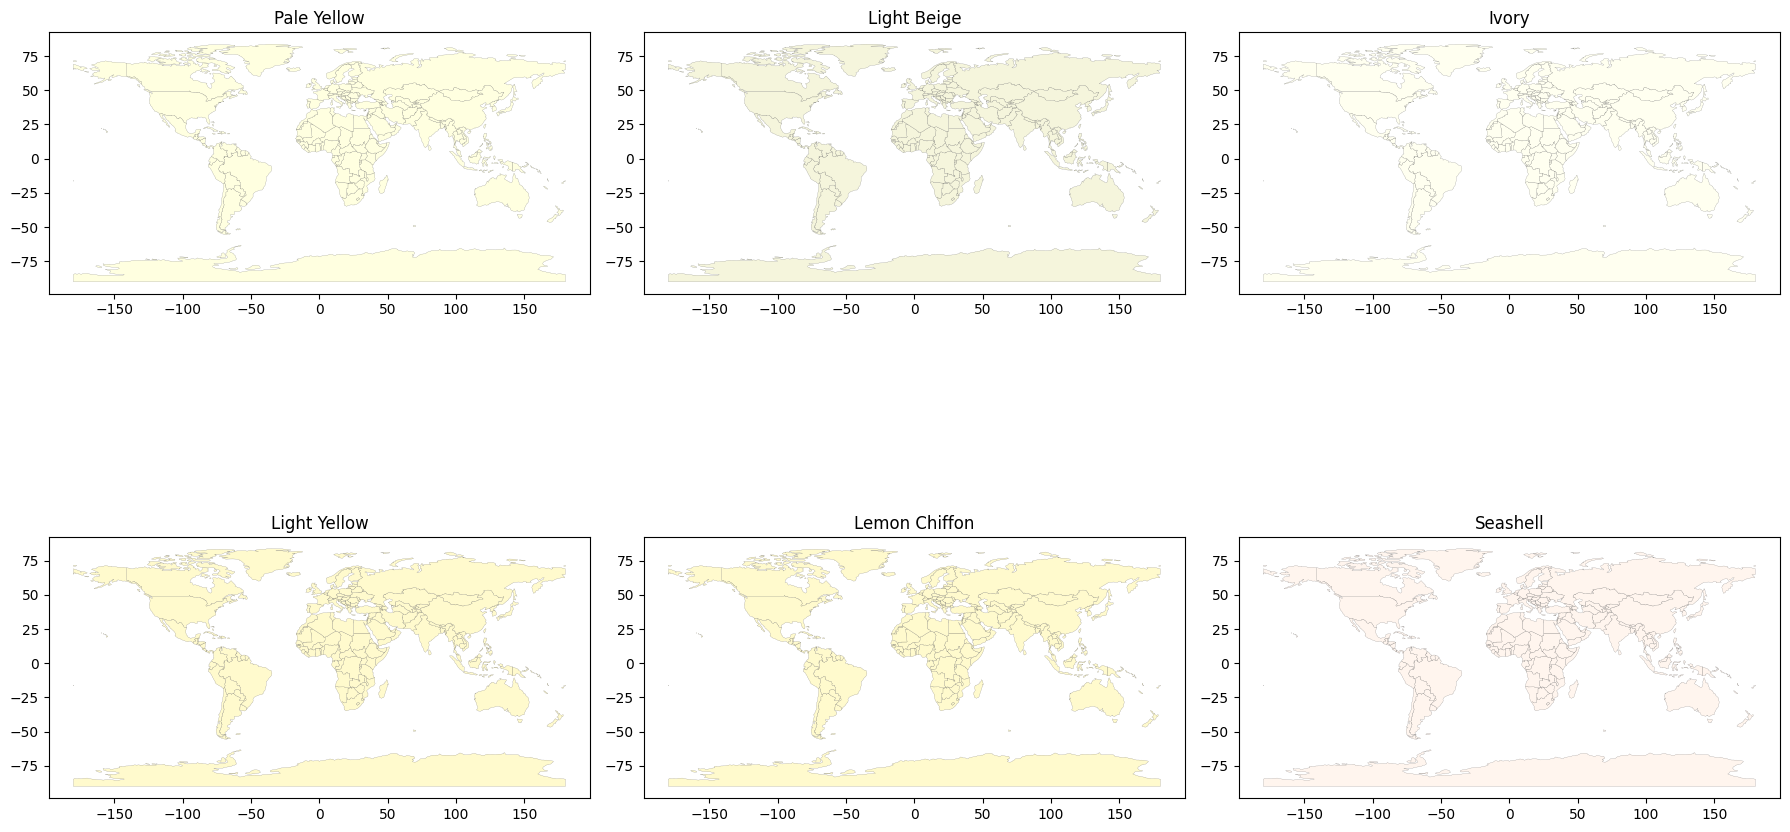

In [42]:
# Load the sample borders data for demonstration purposes
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define the color options
color_options = {
    "Pale Yellow": "#FFFFE0",
    "Light Beige": "#F5F5DC",
    "Ivory": "#FFFFF0",
    "Light Yellow": "#FFFACD",
    "Lemon Chiffon": "#FFFACD",
    "Seashell": "#FFF5EE"
}

# Create subplots for each color option
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot the map with each color option
for ax, (color_name, color_code) in zip(axes, color_options.items()):
    world.plot(ax=ax, facecolor=color_code, edgecolor='0.2', linewidth=0.1)
    ax.set_title(color_name)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Tables

In [43]:
metrics4table = [
    'NSE',
    'Alpha-NSE',
    'Beta-NSE',
    'FHV',
    'FMS',
    'FLV'
]

## Read files

In [44]:
# Find all csv files in file_dir and sort them
csv_files = sorted([f for f in os.listdir(file_dir) if f.endswith('.csv')])

# Read the CSV files
data = {}
for file_name in csv_files:
    df = pd.read_csv(file_dir / file_name)

    # Filter the result dataframe to only include the proper basins
    data[file_name] = df

## Compute statistics

In [45]:
# Initialize an empty dictionary to store statistics
statistics = {}

# Calculate statistics for each model
for file_name, df in data.items():
    
    # Lowercase the column names
    df.columns = df.columns.str.lower() 
    # '_' to '-' in column names
    df.columns = df.columns.str.replace('_', '-') 
    
    case_id = ('_').join(file_name.split('.')[0].split('_')[-2:])
    
    # If NSE is in the columns, count the number of basins with NSE < 0 and exclude those rows after
    if 'nse' in df.columns:
        n_basins_nse_lt_0 = df[df['nse'] <= 0].shape[0]
        # Set negative NSE values to 0
        df['nse'] = df['nse'].apply(lambda x: 0 if x < 0 else x)
        median = df['nse'].median()
        mean = df['nse'].mean()
        statistics[case_id] = {'nse': {
            'median': median,
            'mean': mean,
        }}
        statistics[case_id]['n_basins_nse_lt_0'] = n_basins_nse_lt_0
    
    # For each metric, find median- for NSE calculate mean, and number of basins with NSE < 0 (exclude those from all the statistics)
    for met in  metrics4table:
        
        met = met.lower()
        # Compute the statistics
        if met != 'nse':
            median = df[met].median()
            statistics[case_id][met] = {
                'median': median,
            }

# Create DataFrame from statistics dictionary
df_statistics = pd.DataFrame(statistics).transpose()

## LaTeX table

In [46]:
# Convert data to DataFrame
df_statistics = pd.DataFrame(statistics).T

# Convert nested dictionaries to individual columns
df_statistics['nse_mean'] = df_statistics['nse'].apply(lambda x: round(x['mean'], 3))
df_statistics['nse_median'] = df_statistics['nse'].apply(lambda x: round(x['median'], 3))
df_statistics['n_basins_nse_lt_0_count'] = df_statistics['n_basins_nse_lt_0']
df_statistics['alpha-nse_median'] = df_statistics['alpha-nse'].apply(lambda x: round(x['median'], 3))
df_statistics['beta-nse_median'] = df_statistics['beta-nse'].apply(lambda x: round(x['median'], 3))
df_statistics['fhv_median'] = df_statistics['fhv'].apply(lambda x: round(x['median'], 1))
df_statistics['fms_median'] = df_statistics['fms'].apply(lambda x: round(x['median'], 1))
df_statistics['flv_median'] = df_statistics['flv'].apply(lambda x: round(x['median'], 1))

# Drop unnecessary columns
df_statistics.drop(columns=['nse', 'n_basins_nse_lt_0', 'alpha-nse', 'beta-nse', 'fhv', 'fms', 'flv'], inplace=True)

# Ensure the 'n_basins_nse_lt_0_count' column is numeric
df_statistics['n_basins_nse_lt_0_count'] = pd.to_numeric(df_statistics['n_basins_nse_lt_0_count'])

# Ensure only numerical columns are selected for mean calculation
numeric_cols = df_statistics.select_dtypes(include=['float64', 'int']).columns

# Add a row for the mean values of the statistics
mean_values = df_statistics.loc[df_statistics.index != 'ensemble_metrics', numeric_cols].mean()
# Round the mean values to 3 decimal places
mean_values = mean_values.round(3)

# Create a new DataFrame for the mean values
df_mean = pd.DataFrame(mean_values).transpose()
df_mean.index = ['seeds_mean']

# Add the std values to the DataFrame
std_values = df_statistics.loc[df_statistics.index != 'ensemble_metrics', numeric_cols].std()
# Round the std values to 3 decimal places
std_values = std_values.round(3)

# Create a new DataFrame for the std values
df_std = pd.DataFrame(std_values).transpose()
df_std.index = ['seeds_std']

# Insert the mean row before the 'ensemble_metrics' row
idx = df_statistics.index.get_loc('ensemble_metrics')
df_statistics = pd.concat([df_statistics.iloc[:idx], df_mean, df_std, df_statistics.iloc[idx:]])

display(df_statistics)

# Convert DataFrame to LaTeX table format
latex_table = df_statistics.to_latex(
    index=True,
    header=True,
    float_format="%.3f"
)

print(latex_table)

,nse_mean,nse_median,n_basins_nse_lt_0_count,alpha-nse_median,beta-nse_median,fhv_median,fms_median,flv_median
111,0.716,0.760,10.000,0.911,-0.009,-9.800,-8.500,-0.500
222,0.714,0.751,8.000,0.922,-0.003,-7.900,-9.400,-4.200
333,0.717,0.764,9.000,0.913,-0.003,-10.500,-9.300,-5.600
444,0.721,0.767,10.000,0.918,-0.005,-8.900,-9.300,-1.500
555,0.715,0.758,8.000,0.919,-0.008,-8.700,-8.300,-8.800
666,0.720,0.763,8.000,0.912,-0.002,-9.000,-10.300,1.700
777,0.724,0.764,5.000,0.923,-0.000,-8.900,-9.200,-5.500
888,0.720,0.761,3.000,0.908,-0.008,-10.100,-7.600,-1.500
seeds_mean,0.718,0.761,7.625,0.916,-0.005,-9.225,-8.988,-3.238
seeds_std,0.003,0.005,2.446,0.005,0.003,0.846,0.825,3.391


\begin{tabular}{lrrrrrrrr}
\toprule
 & nse_mean & nse_median & n_basins_nse_lt_0_count & alpha-nse_median & beta-nse_median & fhv_median & fms_median & flv_median \\
\midrule
111 & 0.716 & 0.760 & 10.000 & 0.911 & -0.009 & -9.800 & -8.500 & -0.500 \\
222 & 0.714 & 0.751 & 8.000 & 0.922 & -0.003 & -7.900 & -9.400 & -4.200 \\
333 & 0.717 & 0.764 & 9.000 & 0.913 & -0.003 & -10.500 & -9.300 & -5.600 \\
444 & 0.721 & 0.767 & 10.000 & 0.918 & -0.005 & -8.900 & -9.300 & -1.500 \\
555 & 0.715 & 0.758 & 8.000 & 0.919 & -0.008 & -8.700 & -8.300 & -8.800 \\
666 & 0.720 & 0.763 & 8.000 & 0.912 & -0.002 & -9.000 & -10.300 & 1.700 \\
777 & 0.724 & 0.764 & 5.000 & 0.923 & -0.000 & -8.900 & -9.200 & -5.500 \\
888 & 0.720 & 0.761 & 3.000 & 0.908 & -0.008 & -10.100 & -7.600 & -1.500 \\
seeds_mean & 0.718 & 0.761 & 7.625 & 0.916 & -0.005 & -9.225 & -8.988 & -3.238 \\
seeds_std & 0.003 & 0.005 & 2.446 & 0.005 & 0.003 & 0.846 & 0.825 & 3.391 \\
ensemble_metrics & 0.760 & 0.802 & 2.000 & 0.901 & -0.005 & -1